## Importing/Cleaning Data

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk

# Module level imports
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [7]:
train = pd.read_csv("./data/train.csv")  
test = pd.read_csv("./data/test.csv")

In [8]:
subj1=train.loc[train.subject==1]

## Function definitions

In [22]:
def get_correct_rate(X, Y, classifier):
    """
    Returns the correct rate of a given pre-trained classifier.
    """
    prediction = classifier.predict(X)
    correct_list=prediction==Y
    return sum(correct_list)/len(correct_list)

def knn_fit(X, Y, X_test, Y_test, k_list):
    """
    Returns the correct prediction rates of kNN models for the given values of K.
    """
    correct_rates = []
    for k in k_list:
        k_classifier = KNeighborsClassifier(n_neighbors=k)
        k_classifier.fit(X, Y)
        correct_rates.append(get_correct_rate(X_test, Y_test, k_classifier))
    return correct_rates

## K Nearest Neighbors

First, we use kNN to predict the subject's movement based on all of the predictors.

In [23]:
classifier=KNeighborsClassifier(n_neighbors=5)
classifier.fit(train.drop('Activity',1),train.Activity)
                                

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [31]:
k_vals = [2, 5, 10, 15, 25, 50, 75, 100]
correct_rates = knn_fit(train.drop('Activity', 1), train.Activity, test.drop('Activity', 1), test.Activity, k_vals)


In [34]:
print('Maximum success rate:', "{0:.1f}%".format(100*max(correct_rates)))
print('Optimal value of k:', k_vals[correct_rates.index(max(correct_rates))])

Maximum success rate: 81.7%
Optimal value of k: 10


## Performing LDA

Next, we use Linear Discriminant Analysis to determine the activity based on the entire set of predictors.

In [26]:
lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(train.drop('Activity',1), train.Activity)

/home/matt/Documents/data-science/Data-Science-Final/env/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=2, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [35]:
lda_correct = get_correct_rate(test.drop('Activity', 1), test.Activity, lda)
print("LDA correct rate:", "{0:.1f}%".format(lda_correct*100))

LDA correct rate: 96.4%


This is a very high correct classification rate - however, it doesn't show the whole story of the predictors. Let's plot the LDA components of the variables.

/home/matt/Documents/data-science/Data-Science-Final/env/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


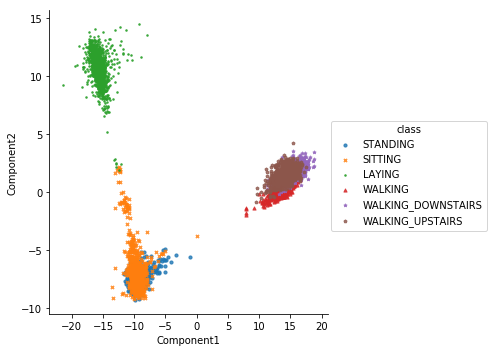

In [37]:
predicted_train = lda.predict(train.drop('Activity', 1))
transform_points = lda.fit_transform(train.drop('Activity', 1), train.Activity)
transform_data = pd.DataFrame(transform_points)
transform_data.columns = ['Component1', 'Component2']
transform_data['class'] = np.asarray(predicted_train)
sns.lmplot( x="Component1", y="Component2", data=transform_data, fit_reg=False, hue='class', legend=True, markers=["o", "x", ".", "^", "*", "p"], scatter_kws={'s': 10})


Because the variables are collinear, we get a very high correct prediction rate, but the LDA coefficients provided are less interpretable. 

## Predicting Activity with Data Subsets

In order to reuct collinearity, it makes sense to find a subset of the data to use for activity prediction. We first try the simple method of just selecting the mean predictors, starting with kNN.

In [43]:
mean_acc_train = train.iloc[:,0:3]
mean_acc_test = test.iloc[:,0:3]

In [44]:
classifier=KNeighborsClassifier(n_neighbors=100)
classifier.fit(mean_acc_train, train.Activity)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=100, p=2,
           weights='uniform')

In [45]:
correct_list = knn_fit(mean_acc_train, train.Activity, mean_acc_test, test.Activity, k_vals)

In [47]:
print('Maximum success rate:', "{0:.1f}%".format(100*max(correct_list)))
print('Optimal value of k:', k_vals[correct_list.index(max(correct_list))])

Maximum success rate: 48.3%
Optimal value of k: 75


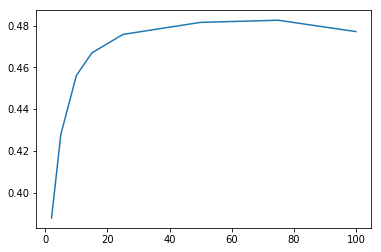

In [48]:
plt.plot(k_vals, correct_list)
plt.show()

## Performing LDA with mean accel data

Next, we perform LDA with this mean acceleration predictor subset.

In [51]:
lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(mean_acc_train, train.Activity)

LinearDiscriminantAnalysis(n_components=2, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [52]:
lda_correct = get_correct_rate(mean_acc_test, test.Activity, lda)
print("LDA correct rate:", "{0:.1f}%".format(lda_correct*100))

LDA correct rate: 22.0%


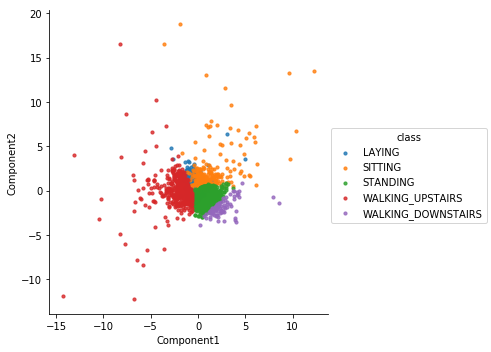

In [55]:
predicted_train = lda.predict(mean_acc_train)
transform_points = lda.fit_transform(mean_acc_train, train.Activity)
transform_data = pd.DataFrame(transform_points)
transform_data.columns = ['Component1', 'Component2']
transform_data['class'] = np.asarray(predicted_train)
sns.lmplot( x="Component1", y="Component2", data=transform_data, fit_reg=False, hue='class', legend=True, scatter_kws={'s': 10})


Here, we have reduced collinearity, but at the expense of greatly reducing model accuracy.

## Comparison of Predictors vs. Predictor Subsets

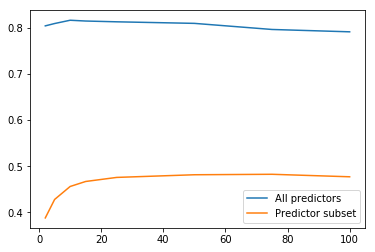

In [57]:
plt.plot(k_vals, correct_rates)
plt.plot(k_vals, correct_list)
plt.legend(['All predictors', 'Predictor subset'])
plt.show()